# Oscillator-based speech syllabification algorithm

Python implementation of 
> Räsänen, Doyle & Frank (2018). Pre-linguistic segmentation of speech into syllable-like units. Cognition, Vol. 171, pp. 130–150.

Based on the Matlab implementation available here: https://github.com/orasanen/thetaOscillator

The peak detection algorithm is from: https://gist.github.com/endolith/250860#file-peakdetect-py

The gammatone filterbank uses: http://detly.github.io/gammatone/filters.html 


**License:** The work is under a GNU General Public License v3.0 

## Peak detection function
Original code:  https://gist.github.com/endolith/250860#file-peakdetect-py

In [1]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    v = asarray(v)
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

## ThetaOscillator function

Original Matlab code here: Based on the Matlab implementation available here: https://github.com/orasanen/thetaOscillator

In [2]:
def thetaOscillator(ENVELOPE, f=5, Q=0.5, thr=0.025, verbose=1):
    
    N = 8;# How many most energetic bands to use (default = 8)

    if N > ENVELOPE.size:
        print ('WARNING: Input dimensionality smaller than the N parameter. Using all frequency bands.');
    # %% Find correct delay compensation (readily tabulated)

    a = np.array([[72, 34, 22, 16, 12, 9, 8, 6, 5, 4, 3, 3, 2, 2, 1, 0, 0, 0, 0, 0],
        [107, 52, 34, 25, 19, 16, 13, 11, 10, 9, 8, 7, 6, 5, 5, 4, 4, 4, 3, 3],
        [129, 64, 42, 31, 24, 20, 17, 14, 13, 11, 10, 9, 8, 7, 7, 6, 6, 5, 5, 4],
        [145, 72, 47, 35, 28, 23, 19, 17, 15, 13, 12, 10, 9, 9, 8, 7, 7, 6, 6, 5],
        [157, 78, 51, 38, 30, 25, 21, 18, 16, 14, 13, 12, 11, 10, 9, 8, 8, 7, 7, 6],
        [167, 83, 55, 41, 32, 27, 23, 19, 17, 15, 14, 12, 11, 10, 10, 9, 8, 8, 7, 7],
        [175, 87, 57, 43, 34, 28, 24, 21, 18, 16, 15, 13, 12, 11, 10, 9, 9, 8, 8, 7],
        [181, 90, 59, 44, 35, 29, 25, 21, 19, 17, 15, 14, 13, 12, 11, 10, 9, 9, 8, 8],
        [187, 93, 61, 46, 36, 30, 25, 22, 19, 17, 16, 14, 13, 12, 11, 10, 10, 9, 8, 8],
        [191, 95, 63, 47, 37, 31, 26, 23, 20, 18, 16, 15, 13, 12, 11, 11, 10, 9, 9, 8]]);

    i1 = max(0,min(10,round(Q*10)));
    i2 = max(0,min(20,round(f)));

    delay_compensation = a[i1-1][i2-1];
    
    # Get oscillator mass
    T = 1./f;   # Oscillator period
    k = 1;      # Fix spring constant k = 1, define only mass
    b = 2*np.pi/T; 
    m = k/b**2;  # Mass of the oscillator

    
    # % Get oscillator damping coefficient
    c = np.sqrt(m*k)/Q;
    
    if(verbose):
        print('Oscillator Q-value: %0.4f, center frequency: %0.1f Hz, bandwidth: %0.1f Hz.\n'%(Q,1/T,1/T/Q));

    # Do zero padding
    e = np.transpose(ENVELOPE);
    e = np.vstack((e,np.zeros((500, e.shape[1]))))
    F = e.shape[1] # Number of frequency channels
    
    # Get oscillator amplitudes as a function of time
    x = np.zeros((e.shape[0],F));
    a = np.zeros((e.shape[0],F));
    v = np.zeros((e.shape[0],F));
                
    for t in range(1,e.shape[0]):        
        for cf in range(F):
            f_up = e[t,cf]; # driving positive force 
            f_down = -k*x[t-1,cf]-c*v[t-1,cf];
            f_tot = f_up+f_down; # Total force
            # Get acceleration from force
            a[t,cf] = f_tot/m;
                
            # Get velocity from acceleration
            v[t,cf] = v[t-1,cf]+a[t,cf]*0.001; # assumes 1000 Hz sampling
            # Get position from velocity
            x[t,cf] = x[t-1,cf]+v[t,cf]*0.001;                

    
    # Perform group delay correction by removing samples from the
    # beginning and adding zeroes to the end
    for f in range(F):
        if(delay_compensation):
            x[:,f] = np.append(x[delay_compensation:,f],np.zeros((delay_compensation,1)));
    
    x = x[:-500]; # Remove zero-padding
    
    # Combine N most energetic bands to get sonority envelope
    tmp = x;
    tmp = tmp-np.min(tmp)+0.00001;
    x = np.zeros((tmp.shape[0],1));

    for zz in range(tmp.shape[0]):
        sort_tmp = np.sort(tmp[zz,:],axis=0)[::-1];  
        x[zz] = sum((np.log10(sort_tmp[:N])));                

    # Scale sonority envelope between 0 and 1
    x = x-np.min(x);
    x = x/np.max(x);
    return x

## Run the syllable detection over an audio signal

In [3]:
# Gammatone Python module
#!pip3 install git+https://github.com/detly/gammatone.git

In [4]:
import librosa
import numpy as np
import gammatone.filters
from scipy.signal import hilbert

# Generate Gammatone filterbank center frequencies (log-spacing)
minfreq = 50
maxfreq = 7500
bands = 20

cfs = np.zeros((bands,1));
const = (maxfreq/minfreq)**(1/(bands-1));
#const = 1.3018

cfs[0] = 50;
for k in range(bands-1):
    cfs[k+1] = cfs[k]*const;
    

# Read the audio data
wav_data, fs = librosa.load('deasemenea.wav')
wav_data = librosa.resample(wav_data,fs,16000);
fs = 16000;
# Compute gammatone envelopes and downsample to 1000 Hz
coefs = gammatone.filters.make_erb_filters(fs, cfs, width=1.0)
filtered_signal = gammatone.filters.erb_filterbank(wav_data, coefs)
hilbert_envelope = np.abs(hilbert(filtered_signal))
env = librosa.resample(hilbert_envelope,fs,1000);

# Run oscillator-based segmentation
Q_value = 0.5;  # Q-value of the oscillator, default = 0.5 = critical damping
center_frequency = 5; # in Hz
threshold = 0.01;

# Get the sonority function
outh = thetaOscillator(env,center_frequency,Q_value,threshold)

Oscillator Q-value: 0.5000, center frequency: 5.0 Hz, bandwidth: 10.0 Hz.



Text(0.5, 1.0, 'First 10 Gammatone Filter Envelopes')

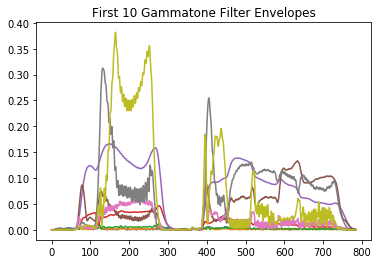

In [5]:
import matplotlib.pylab as pl
%matplotlib inline
pl.plot(env[1:10].transpose());
pl.title('First 10 Gammatone Filter Envelopes')

In [8]:
# Detect the peaks and valleys of the sonority function
peaks,valleys = peakdet(outh,threshold); 
if len(valleys) and len(peaks):
    valley_indices = valleys[:,0]
    peak_indices = peaks[:,0]

    # Add signal onset if not detected by valley picking 
    if valley_indices[0] > 50:
        valley_indices = np.insert(valley_indices,0,0)
    if valley_indices[-1] < env.shape[1] -50:
        valley_indices = np.append(valley_indices,env.shape[1])
else:
    valley_indices = [0, len(env)]

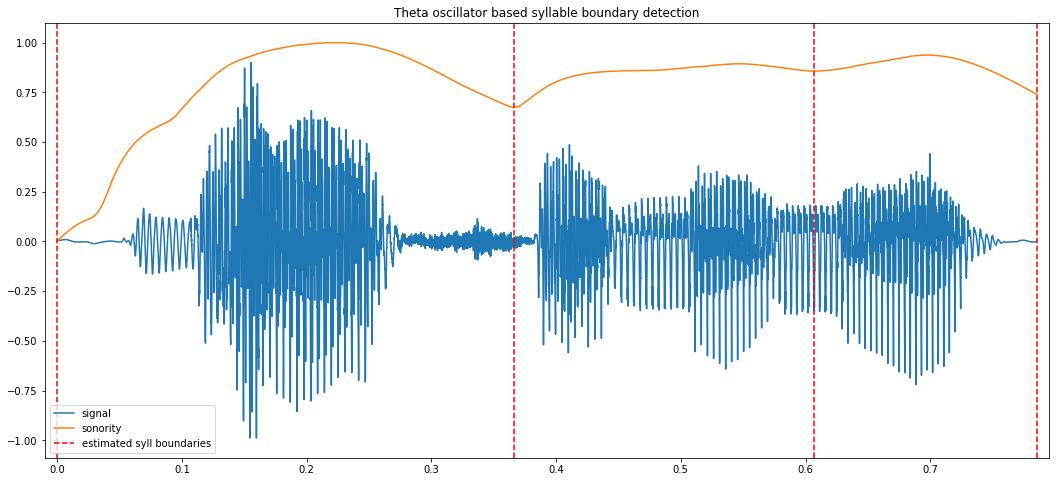

In [9]:
# Plot the results
pl.figure(figsize=(18,8))
time_axis = [i*1./fs for i in range(len(wav_data))]
pl.plot(time_axis, wav_data)
pl.xlim((-0.01, (len(wav_data))*1./fs+0.01))
time_axis = [i*1./1000 for i in range(len(outh))]
pl.plot(time_axis, outh)

for vi in valley_indices:
    pl.axvline(vi*1./1000, ymin=0, ymax=1, color='r', linestyle='dashed')
    
## Plot syll nuclei
#for pi in peak_indices:
#    pl.axvline(pi*1./1000, ymin=0, ymax=1, color = 'g', linestyle='dashed')

## Plot true boundaries
#zz = [0.264, 0.446, 0.573];
#for z in zz:
#    pl.axvline(z, ymin=0, ymax=1, color = 'k', linestyle='dashed')
    
    
pl.legend(['signal', 'sonority','estimated syll boundaries']);
pl.title('Theta oscillator based syllable boundary detection');

In [10]:
import IPython
IPython.display.Audio(wav_data, rate=fs)